## Hypothesis II - Proposed Modeling Approach III

##### Input: Parametric UMAP Dimensions

##### Downstream Model: LASSO

##### Validation: 5-fold CV


In [1]:
import operator
import os
import datetime
import gc
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import tensorflow as tf
from tensorflow.keras import layers

import umap
from umap import UMAP
from umap.parametric_umap import ParametricUMAP

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso, LassoCV

import shap
import cv2

c:\Users\Fared.Farag\AppData\Local\pypoetry\Cache\virtualenvs\umap-Kp0glNbV-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Remove noData Pixels Function


In [2]:
def filterNoData2(band):
    band_filtered = band

    operatorLookup = {">": operator.gt, "<": operator.lt}

    threshold = 100
    comparison = ">"

    # check if noData value is extremely large or small
    if len(band_filtered[band_filtered > 100]) > 0:
        threshold = 100
        comparison = ">"

    elif len(band_filtered[band_filtered < -100]) > 0:
        threshold = -100
        comparison = "<"

    op = operatorLookup.get(comparison)

    # find the indices of the non-noData pixels
    nonNoDataIndices = np.where(~op(band, threshold))

    # determine the minimum and maximum row and column indices of the non-noData pixels
    rowIndices = (min(nonNoDataIndices[0]), max(nonNoDataIndices[0]))
    colIndices = (min(nonNoDataIndices[1]), max(nonNoDataIndices[1]))

    # extract a subarray that only includes the non-noData pixels
    croppedImg = band[
        rowIndices[0] : rowIndices[1] + 1, colIndices[0] : colIndices[1] + 1
    ]

    band_filtered = croppedImg

    # iterate through rows
    offset = 0
    for row in range(0, band_filtered.shape[0]):
        # delete row if more than 1/3 of it contains noData values
        if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 3:
            # if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 0.15 * len(band_filtered[row - offset]):
            # print(f"Deleting row {row} with offset {offset}")
            band_filtered = np.delete(band_filtered, row - offset, 0)
            offset += 1

        row += 1

    # iterate through cols
    offset = 0
    for col in range(0, band_filtered.shape[1]):
        if len(np.argwhere(op(band_filtered[:, col - offset], threshold))) > 0:
            # print(f"Deleting column {col} with offset {offset}")
            band_filtered = np.delete(band_filtered, col - offset, 1)
            offset += 1

        col += 1

    return band_filtered

#### Load Yield Data


In [2]:
df_2021 = pd.read_csv("../../../../Datasets/Agronomic/2021/Dataset_2021.csv")
df_2021 = df_2021.sort_values(by="Plot_Number")

# remove missing yield
df_2021 = df_2021[df_2021["Yield"].notna()].reset_index(drop=True)

# get plot Numbers
df_2021["Plot_Number"] = df_2021["Plot_Number"].astype(str)
plotNumbers_2021 = list(df_2021["Plot_Number"].unique())

# keep only necessary attributes
df_2021 = df_2021.iloc[:, [0, 1, 2, 5, 6, 7, 11]]
df_2021

,Plot_Number,Rice_Cultivar,Experiment_Name,Nitrogen_Rate,Replicate,Yield,Heading_100
0,33761,IAC600,Tiara,75,1,6.002350,66
1,33762,Tiara,Tiara,75,1,5.922051,71
2,33763,Sierra,Tiara,75,1,8.331022,83
3,33764,Scarlett,Tiara,75,1,10.565055,79
4,33765,Tiara,Tiara,75,1,6.693495,70
...,...,...,...,...,...,...,...
219,35848,WAB462-10-3-1,Mini_Core,130,4,8.652218,75
220,35852,Jefferson,Mini_Core,130,4,10.722785,74
221,35853,EMBRAPA 1200,Mini_Core,130,4,10.430267,86
222,35856,XP753,Mini_Core,130,4,21.821254,75


**Split Plots into Train/Test** <br>
The split is done in a leave-one-replicate-out fashion. For each group of plots, one replicate is left out for validaiton while the rest is trained on.


In [3]:
seedCounter = 100
trainPlots = []
testPlots = []

for e in df_2021["Experiment_Name"].unique():
    for c in df_2021[df_2021["Experiment_Name"] == e]["Rice_Cultivar"].unique():
        for n in df_2021[
            (df_2021["Experiment_Name"] == e) & (df_2021["Rice_Cultivar"] == c)
        ]["Nitrogen_Rate"].unique():
            replicates = df_2021[
                (df_2021["Experiment_Name"] == e)
                & (df_2021["Rice_Cultivar"] == c)
                & (df_2021["Nitrogen_Rate"] == n)
            ]["Replicate"].unique()

            # set seed for each random pick for reproducibility
            np.random.seed(seedCounter)
            picked = np.random.choice(replicates)
            seedCounter += 1

            train = df_2021[
                (df_2021["Experiment_Name"] == e)
                & (df_2021["Rice_Cultivar"] == c)
                & (df_2021["Nitrogen_Rate"] == n)
                & (df_2021["Replicate"] != picked)
            ]["Plot_Number"].values

            test = df_2021[
                (df_2021["Experiment_Name"] == e)
                & (df_2021["Rice_Cultivar"] == c)
                & (df_2021["Nitrogen_Rate"] == n)
                & (df_2021["Replicate"] == picked)
            ]["Plot_Number"].values

            print(
                f"Experiment: {e}, Cultivar: {c}, Nitrogen: {n} \n"
                f"Train plots: {train}\n"
                f"Test plots: {test}\n"
                f"---------------------------------------------------------------"
            )

            trainPlots.extend(train)
            testPlots.extend(test)

del e, c, n, replicates, seedCounter, train, test

Experiment: Tiara, Cultivar: IAC600, Nitrogen: 75 
Train plots: ['33769' '33771' '33779' '33783']
Test plots: ['33761' '33766']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 150 
Train plots: ['33786' '33788' '33801' '33807']
Test plots: ['33795' '33798']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: IAC600, Nitrogen: 200 
Train plots: ['33821' '33822' '33826' '33832']
Test plots: ['33810' '33816']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 75 
Train plots: ['33762' '33765' '33777' '33781']
Test plots: ['33773' '33775']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nitrogen: 150 
Train plots: ['33785' '33792' '33803' '33804']
Test plots: ['33794' '33799']
---------------------------------------------------------------
Experiment: Tiara, Cultivar: Tiara, Nit

In [4]:
dfTrain = df_2021[df_2021["Plot_Number"].isin(trainPlots)].reset_index(drop=True)
dfTrain

,Plot_Number,Rice_Cultivar,Experiment_Name,Nitrogen_Rate,Replicate,Yield,Heading_100
0,33762,Tiara,Tiara,75,1,5.922051,71
1,33763,Sierra,Tiara,75,1,8.331022,83
2,33764,Scarlett,Tiara,75,1,10.565055,79
3,33765,Tiara,Tiara,75,1,6.693495,70
4,33767,Scarlett,Tiara,75,1,11.173033,79
...,...,...,...,...,...,...,...
146,35839,M-202,Mini_Core,130,3,11.342234,74
147,35841,WAB462-10-3-1,Mini_Core,130,3,7.940998,75
148,35848,WAB462-10-3-1,Mini_Core,130,4,8.652218,75
149,35852,Jefferson,Mini_Core,130,4,10.722785,74


#### Load Transformed Data


In [5]:
LATE_BOOT_DATES = ["06-14-2021", "06-23-2021", "06-30-2021", "07-28-2021"]
embedding = joblib.load("./Saved_Models/Transformed_Data/Train")

dateDf = pd.concat([dfTrain] * len(LATE_BOOT_DATES)).reset_index(drop=True)
dateDf["Date"] = np.nan

start = 0
end = 1
for date in LATE_BOOT_DATES:
    dateDf.iloc[len(dfTrain) * start : len(dfTrain) * end, -1] = date
    start += 1
    end += 1

dfEmbeddingTrain = pd.concat(
    [dateDf.reset_index(drop=True), pd.DataFrame(embedding)], axis=1
)

# rename components
for i in range(len(dateDf.columns), len(dfEmbeddingTrain.columns), 1):
    dfEmbeddingTrain.rename(
        columns={
            dfEmbeddingTrain.columns[i]: "UMAP_" + str(i - len(dateDf.columns) + 1)
        },
        inplace=True,
    )

del start, end, date, dateDf, i

#### Visualize PUMAP Dimensions


In [25]:
# insert emergence dates
tmp = dfEmbeddingTrain.copy()
tmp["Emergence_DOY"] = 140
tmp.loc[tmp["Experiment_Name"] == "Mini_Core", "Emergence_DOY"] = 139

# add 100% heading dates
tmp["Heading_100_DOY"] = tmp["Emergence_DOY"] + tmp["Heading_100"]

# calculate days to 100% heading
tmp["Days_to_100%_Heading"] = tmp.apply(
    lambda x: datetime.datetime.strptime(x["Date"], "%m-%d-%Y").timetuple().tm_yday
    - x["Heading_100_DOY"],
    axis=1,
)

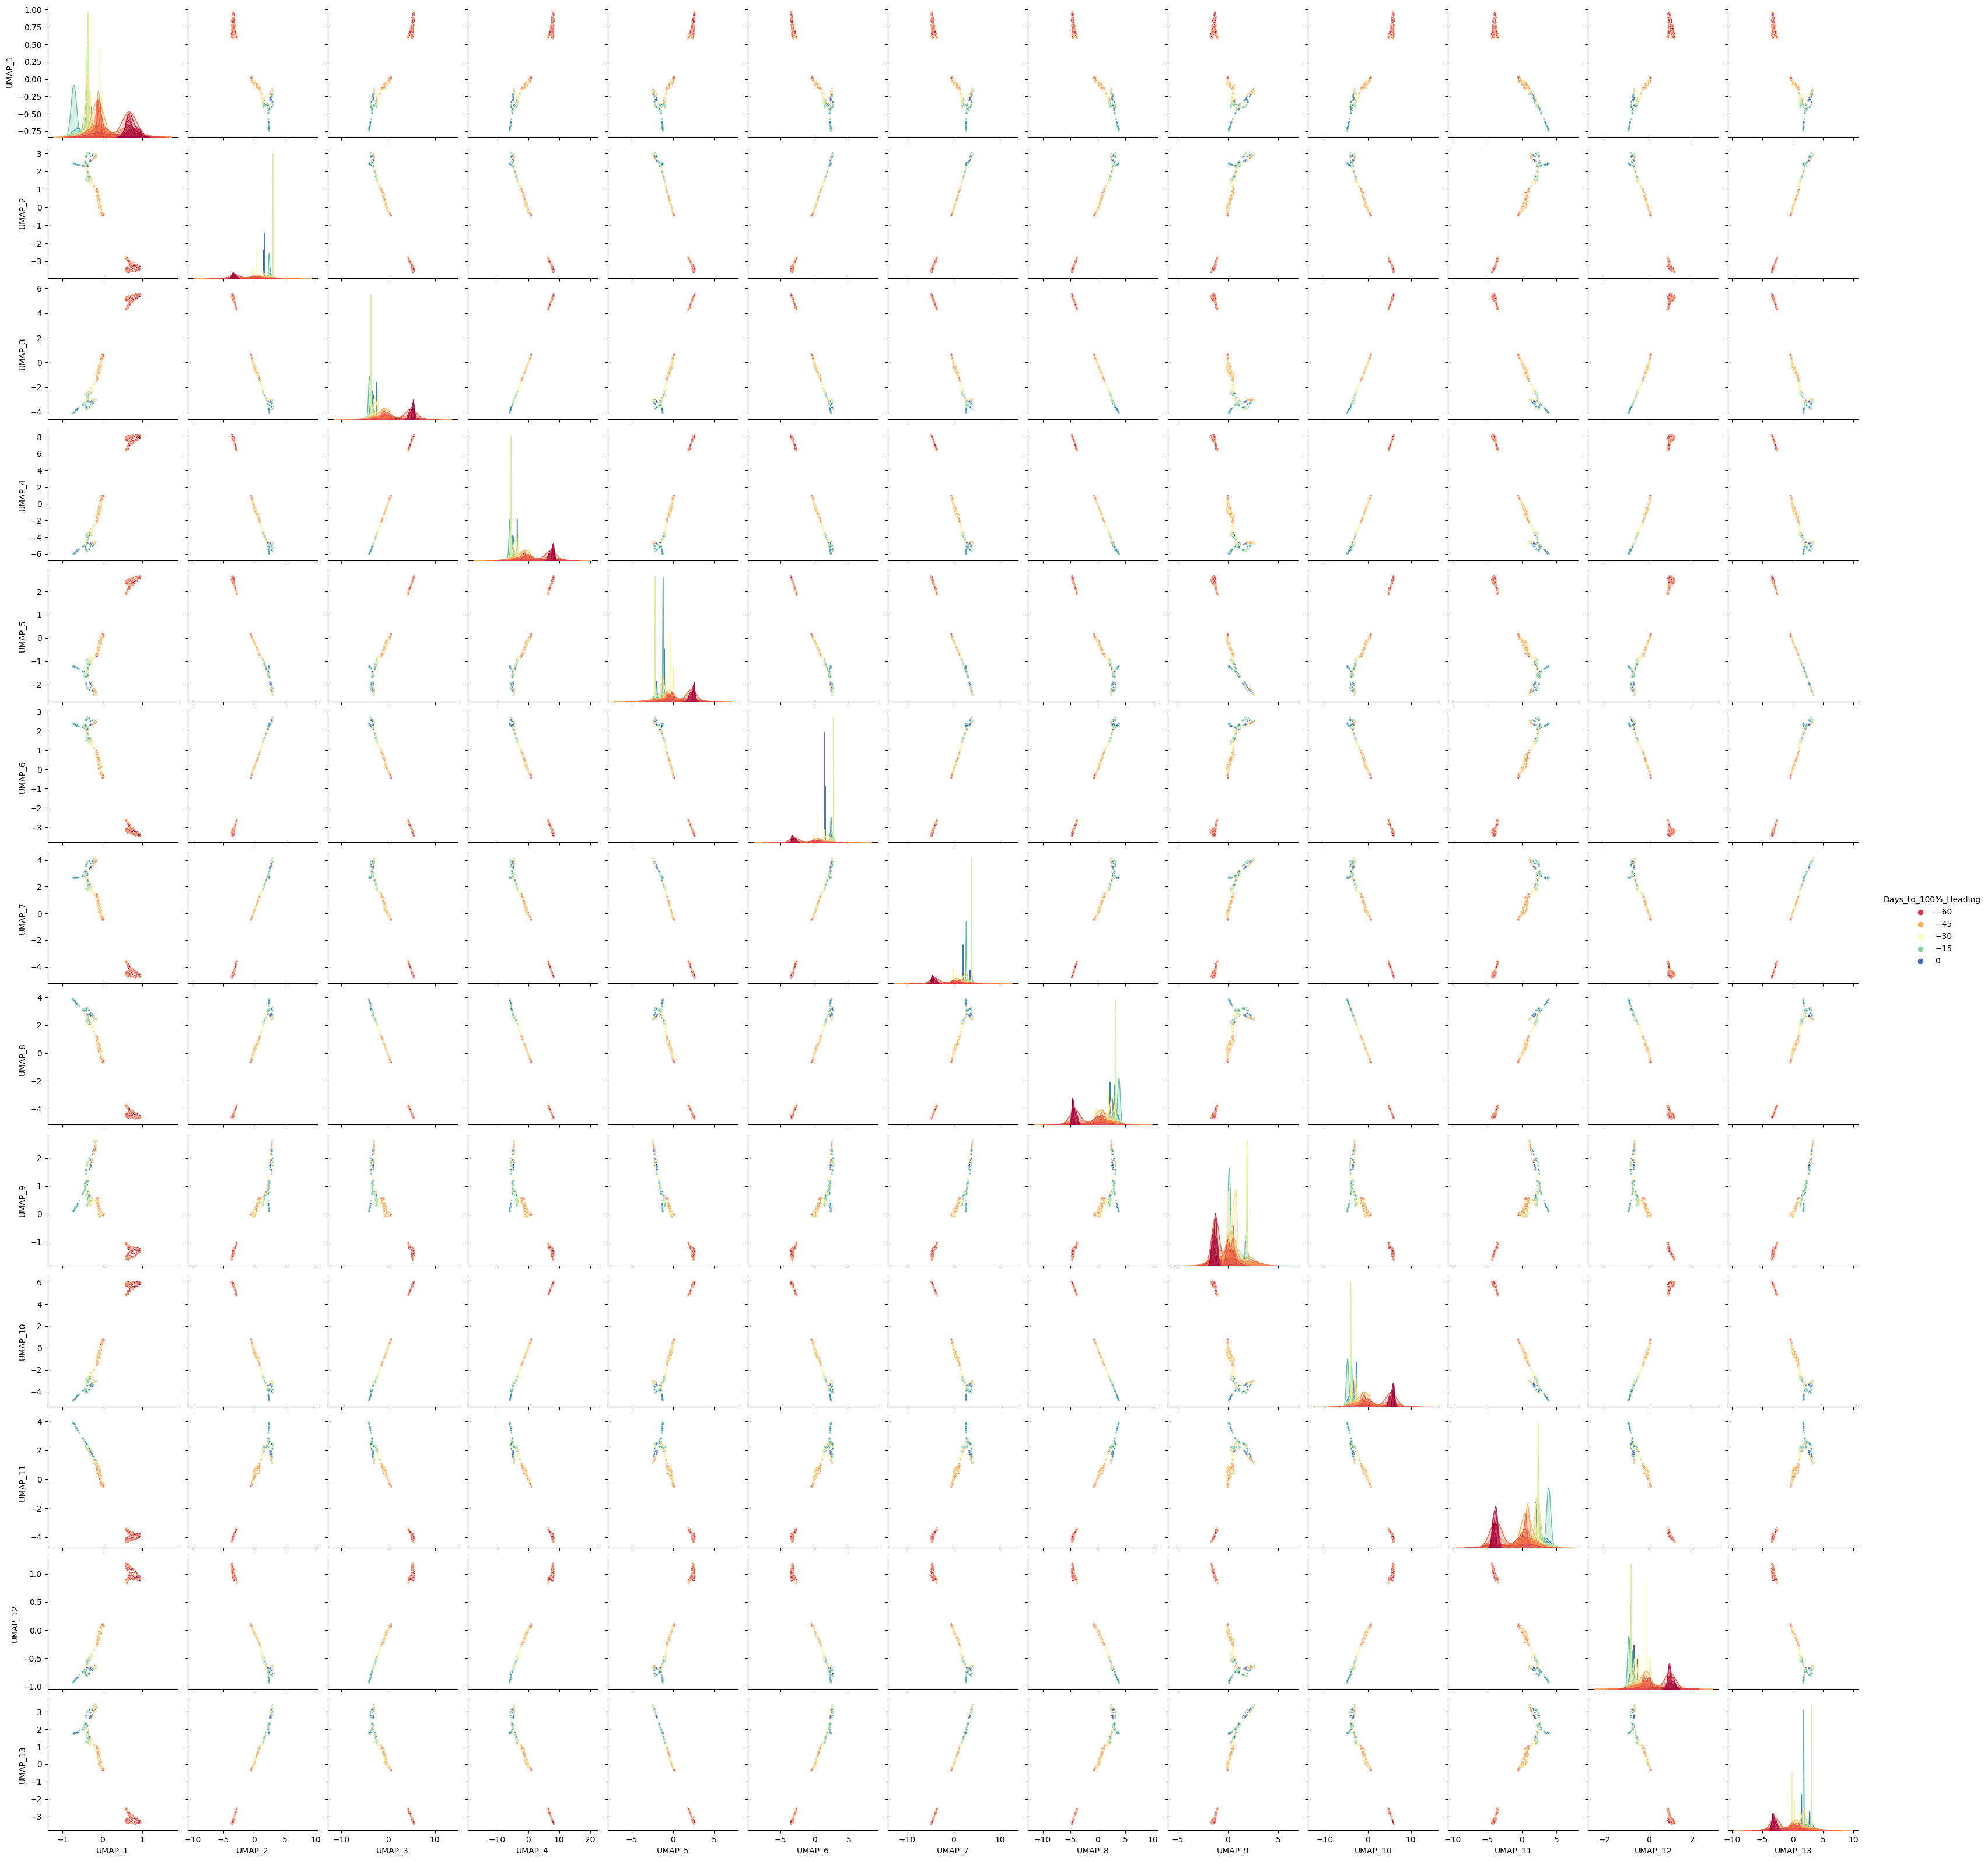

In [26]:
sns.pairplot(
    tmp.loc[
        :,
        ["Days_to_100%_Heading"]
        + list(
            tmp.columns[
                tmp.columns.get_loc("UMAP_1") : tmp.columns.get_loc("UMAP_13") + 1
            ]
        ),
    ],
    hue="Days_to_100%_Heading",
    palette="Spectral",
    plot_kws={"s": 5},
)

#### Preprocess UMAP dimensions


In [28]:
# wide to long then long to wide
dfLongTrain = pd.melt(
    dfEmbeddingTrain,
    id_vars=dfEmbeddingTrain.iloc[:, :8],
    value_vars=dfEmbeddingTrain.iloc[:, 8:],
)

dfWideTrain = pd.pivot(
    dfLongTrain,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTrain.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTrain.columns.tolist()
]

del dfLongTrain

#### Training


In [29]:
def lassoCV_custom(xTrain, yTrain, nfolds, alpha=1):
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=100)

    cvResults = []
    for trainIndices, valIndices in kfold.split(xTrain):
        xTrainCV, xValCV = xTrain[trainIndices], xTrain[valIndices]
        yTrainCV, yValCV = yTrain[trainIndices], yTrain[valIndices]

        # fit model
        lassoModel = Lasso(max_iter=10000, alpha=alpha)
        lassoModel.fit(xTrainCV, yTrainCV)
        preds = lassoModel.predict(xValCV)
        cvResults.append(mean_squared_error(yValCV, preds, squared=False))

    return cvResults

In [30]:
xTrain = dfWideTrain.iloc[:, 6:].values
yTrain = dfWideTrain["Yield"]
N_FOLDS = 5

defaultModel = Lasso(max_iter=10000).fit(xTrain, yTrain)

print(f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS))}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, defaultModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 2.6593100157471987
Training RMSE: 2.626341500782067


#### Tuning Lambda


In [31]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=100)
tunedModel = LassoCV(max_iter=100000, cv=cv, n_jobs=-1).fit(xTrain, yTrain)

#### Visualize CV


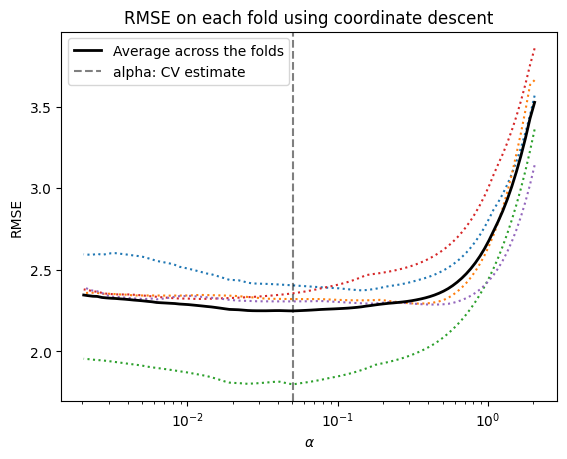

In [32]:
plt.semilogx(tunedModel.alphas_, tunedModel.mse_path_**0.5, linestyle=":")
plt.plot(
    tunedModel.alphas_,
    tunedModel.mse_path_.mean(axis=-1) ** 0.5,
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    tunedModel.alpha_,
    linestyle="--",
    color="black",
    label="alpha: CV estimate",
    alpha=0.5,
)

plt.xlabel(r"$\alpha$")
plt.ylabel("RMSE")
plt.legend()
_ = plt.title(f"RMSE on each fold using coordinate descent")

In [33]:
print(
    f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS, tunedModel.alpha_))}"
)
print(
    f"Training RMSE: {mean_squared_error(yTrain, tunedModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 2.236631492407421
Training RMSE: 2.1781937220391745


#### Interpret Model


In [34]:
explainer = shap.Explainer(lambda x: tunedModel.predict(x), xTrain)
shapValues = explainer.shap_values(xTrain)

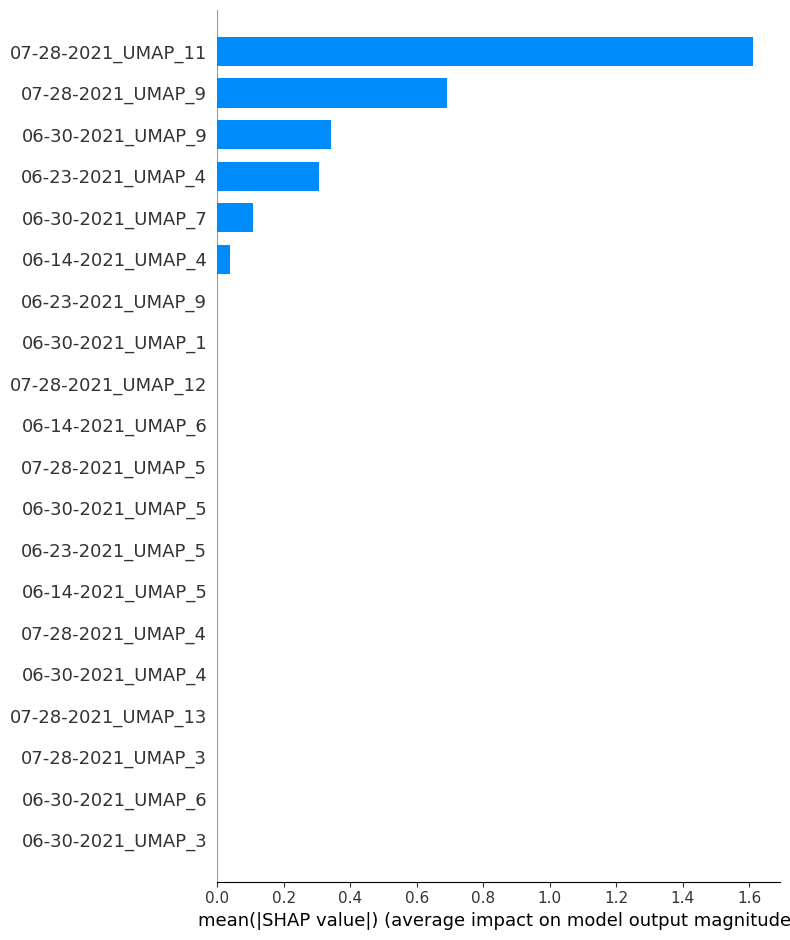

In [35]:
shap.summary_plot(shapValues, plot_type="bar", feature_names=dfWideTrain.columns[6:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


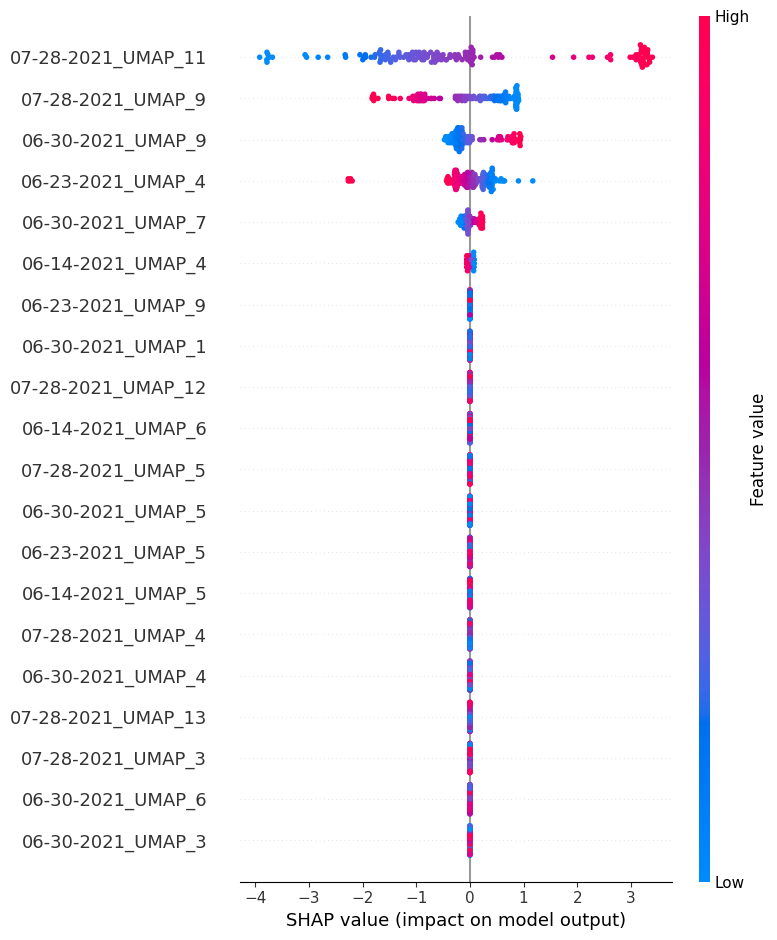

In [36]:
shap.summary_plot(
    shapValues, plot_type="dot", feature_names=dfWideTrain.columns[6:], features=xTrain
)

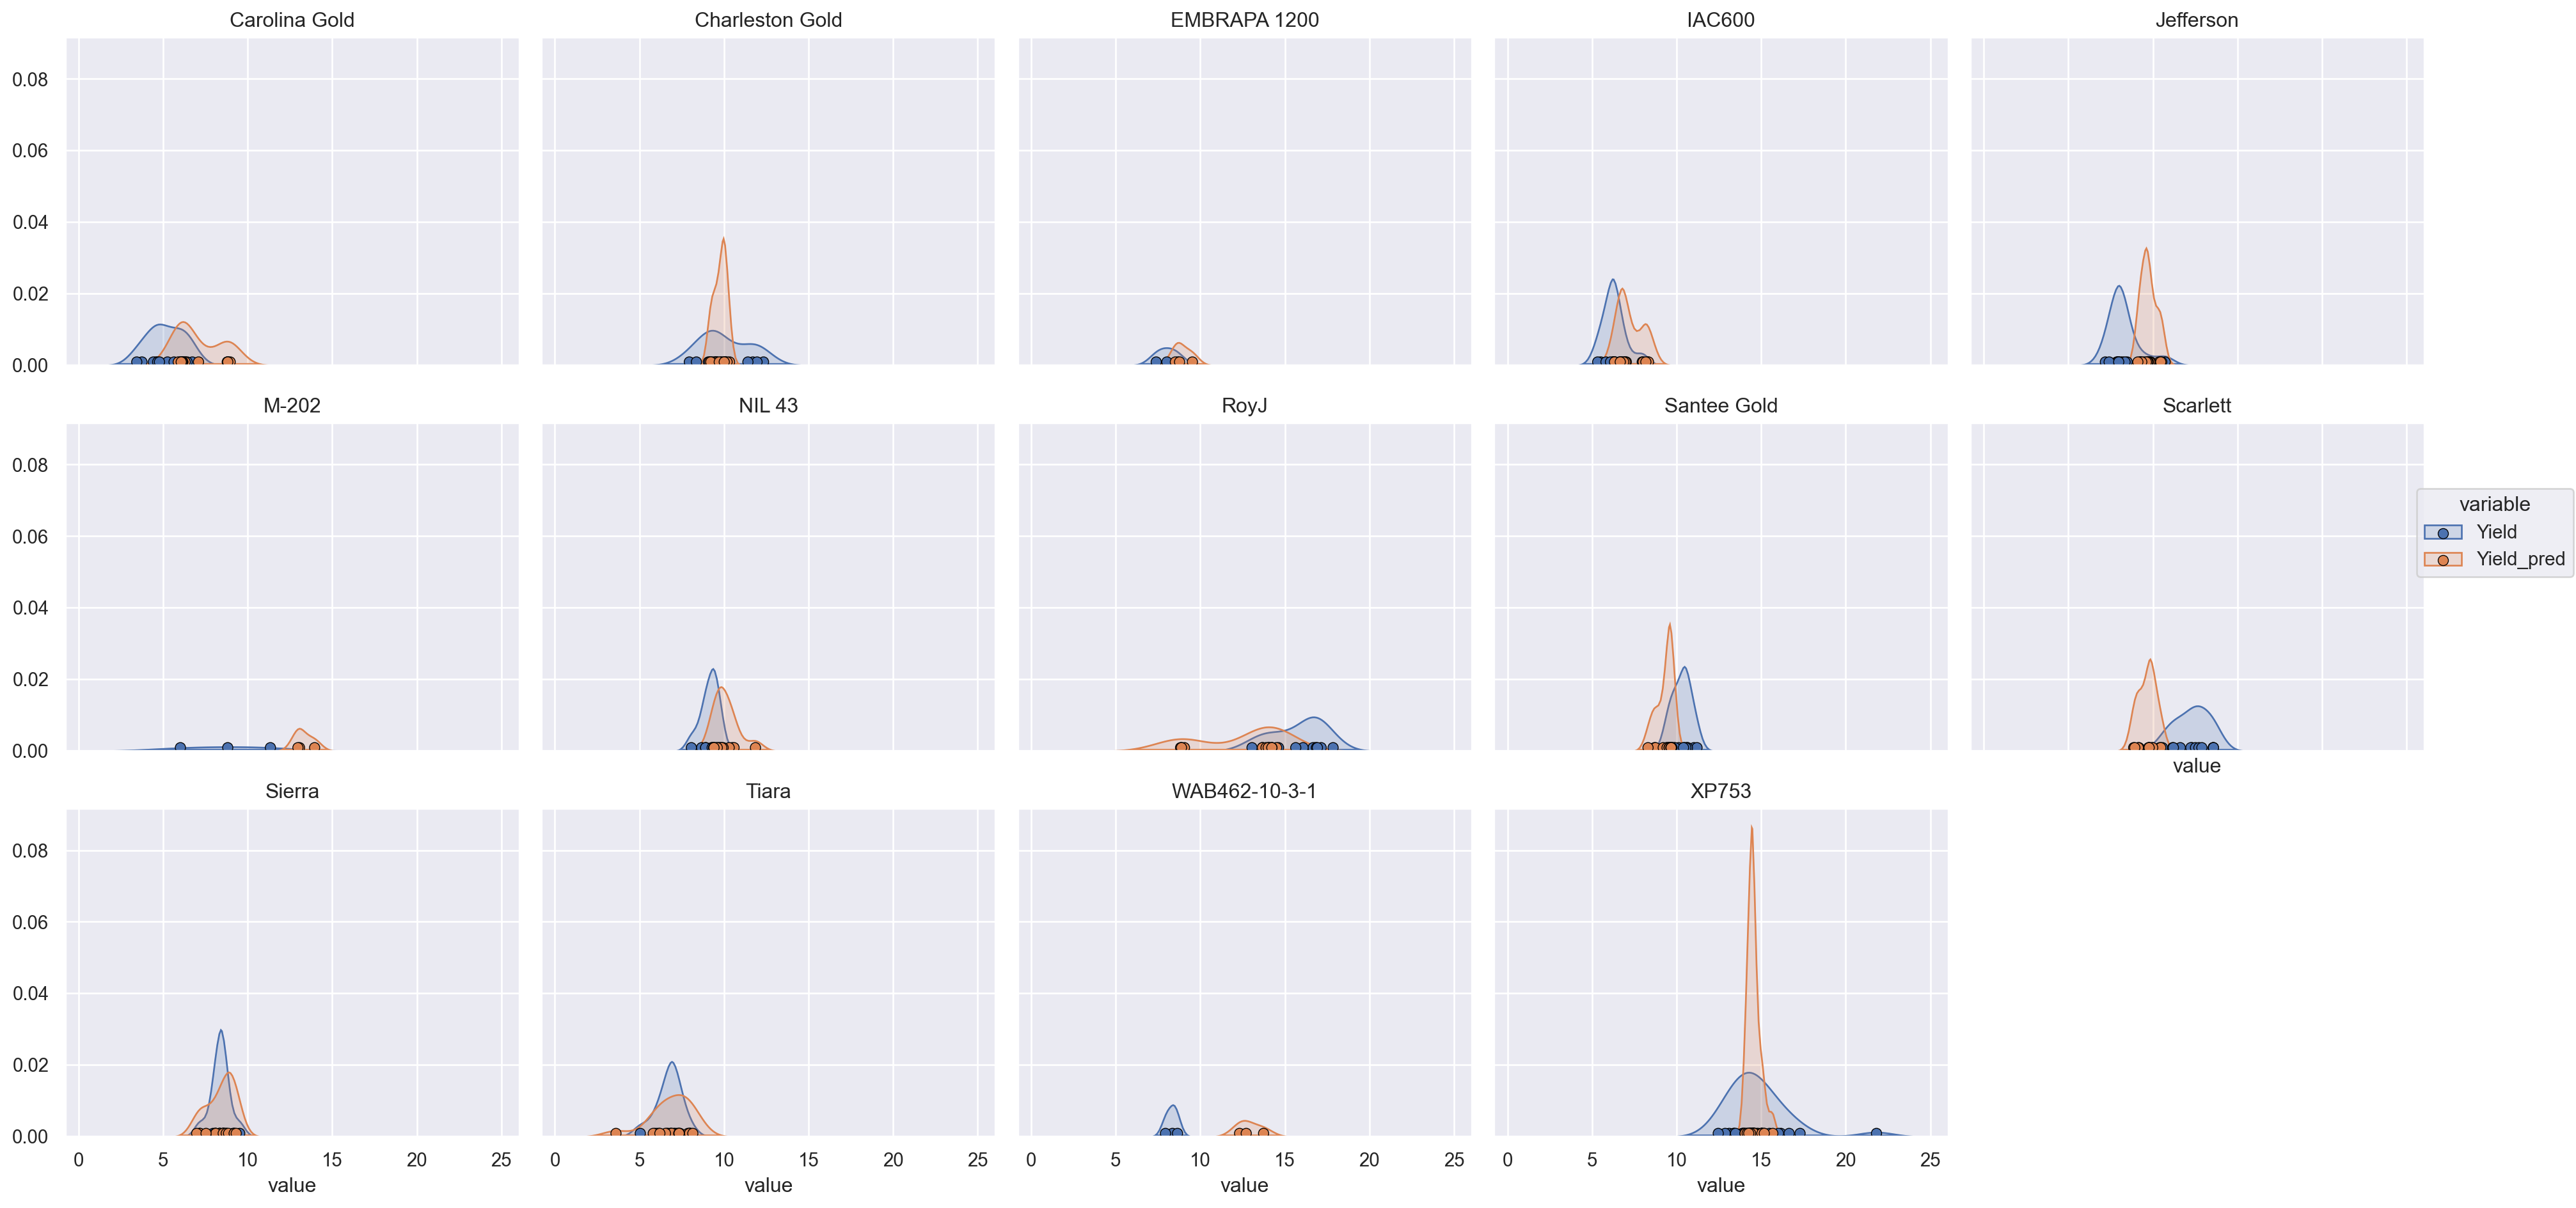

In [38]:
testDf = dfTrain.copy().reset_index(drop=True)
testDf["Yield_pred"] = tunedModel.predict(xTrain)

temp = pd.melt(
    testDf,
    id_vars=testDf.columns[:-3],
    value_vars=["Yield", "Yield_pred"],
)
(
    so.Plot(
        temp,
        x="value",
    )
    .layout(size=(20, 10))
    .facet(
        # col="Experiment_Name",
        # order=[
        #     "Hybrid_XP753",
        #     "Inbred_Jeff + NIL",
        #     "Mini_Core",
        #     "Santee_Gold",
        #     "Tiara",
        # ],
        col="Rice_Cultivar",
        order=sorted(temp["Rice_Cultivar"].unique()),
        wrap=5,
    )
    # .share(x=False, y=False)
    .add(so.Area(), so.KDE(), color="variable")
    .add(so.Dot(edgecolor="black"), y=[0.0008] * len(temp), color="variable")
    # .limit(y=(-0.001,0.06))
    # .scale(color=so.Nominal(order=sorted(temp["Rice_Cultivar"].unique())))
)

# del temp, testDf

### Export Models


In [ ]:
# save tuned model
joblib.dump(tunedModel, "./Saved_Models/H2A3M1")